In [345]:
import numpy as np
from scipy.stats import norm

In [346]:
class NestedMonteCarlo:
    """
    Hereafter, n stands for the number of scenario simulations, m stands for the number of internal loss simulations par scenario.
    """
    simulate_scenario : callable # function of (size)
    simulate_inner_loss : callable # function of (scenario, size)
    loss_threshold : float

    def __init__(self, simulate_scenario, simulate_inner_loss, loss_threshold) -> None:
        self.simulate_scenario = simulate_scenario
        self.simulate_inner_loss = simulate_inner_loss
        self.loss_threshold = loss_threshold

    def estimation_uniform(self, m, n):
        scenarios = self.simulate_scenario(n)
        inner_losses_mean = np.zeros(n)

        for i, scenario in enumerate(scenarios):
            inner_loss = self.simulate_inner_loss(scenario=scenario, size=m)
            inner_losses_mean[i] = np.mean(inner_loss)

        estimator = np.mean(inner_losses_mean >= self.loss_threshold)
        return estimator


    def estimation_sequential(self, m_init, m_average, n, return_info=False):
        scenarios = self.simulate_scenario(n)
        sigmas = np.ones(n)
        m_array = np.zeros(n)
        inner_losses_mean = np.zeros(n)
        inner_losses_square_mean = np.zeros(n)

        for i, scenario in enumerate(scenarios):
            inner_loss = self.simulate_inner_loss(scenario=scenario, size=m_init)
            inner_losses_mean[i] = np.mean(inner_loss)
            inner_losses_square_mean[i] = np.mean(inner_loss**2)
        m_array += m_init

        while m_array.sum() < m_average * n:
            idx_scenario = np.argmin(m_array * np.abs(inner_losses_mean - self.loss_threshold) / sigmas)
            new_inner_loss = self.simulate_inner_loss(scenario=scenarios[idx_scenario], size=1)
            inner_losses_mean[idx_scenario] = m_array[idx_scenario] / (m_array[idx_scenario] + 1) * inner_losses_mean[idx_scenario] + new_inner_loss / (m_array[idx_scenario] + 1) 
            inner_losses_square_mean[idx_scenario] = m_array[idx_scenario] / (m_array[idx_scenario] + 1) * inner_losses_square_mean[idx_scenario] + new_inner_loss**2 / (m_array[idx_scenario] + 1)
            sigmas[idx_scenario] = np.sqrt(inner_losses_square_mean[idx_scenario] - inner_losses_mean[idx_scenario]**2)
            m_array[idx_scenario] += 1
        
        estimator = np.mean(inner_losses_mean >= self.loss_threshold)
        return estimator if not return_info else (estimator, inner_losses_mean, m_array)
    
    def estimation_threshold(self, error_margin, n):
        scenarios = self.simulate_scenario(n)
        sigmas = np.ones(n)
        inner_losses_mean = np.zeros(n)

        for i, scenario in enumerate(scenarios):
            MIN_SCENARIOS = 20
            inner_loss_mean = 0
            inner_loss_square_mean = 0
            m_scenario = 0
            while m_scenario < MIN_SCENARIOS or m_scenario / sigmas[i] * np.abs(inner_loss_mean - self.loss_threshold) < error_margin:
                new_inner_loss = self.simulate_inner_loss(scenario=scenario, size=1)
                inner_loss_mean = m_scenario / (m_scenario + 1) * inner_loss_mean + new_inner_loss / (m_scenario + 1)
                inner_loss_square_mean = m_scenario / (m_scenario + 1) * inner_loss_square_mean + new_inner_loss**2 / (m_scenario + 1)
                sigmas[i] = np.sqrt(inner_loss_square_mean - inner_loss_mean**2)
                m_scenario += 1
            inner_losses_mean[i] = inner_loss_mean

        estimator = np.mean(inner_losses_mean >= self.loss_threshold)
        return estimator

In [ ]:
def get_optimal_beta(alpha)

## Gaussian example

In [348]:
rng = np.random.default_rng(seed=0xBADBADBAD)

def gaussian_simulate_scenario(size, sigma_outer : float = 1, rng : np.random.Generator = rng):
    return rng.normal(loc=0, scale=sigma_outer, size=size)

def gaussian_simulate_inner_loss(size, scenario, sigma_inner : float = 5, rng : np.random.Generator = rng):
    return -scenario + rng.normal(loc=0, scale=sigma_inner, size=size)

threshold_gauss = 2.3263478740408408
norm.cdf(-threshold_gauss)

0.01

In [349]:
nested_mc_gauss = NestedMonteCarlo(
    simulate_scenario=gaussian_simulate_scenario,
    simulate_inner_loss=gaussian_simulate_inner_loss,
    loss_threshold=threshold_gauss,
)

In [350]:
nested_mc_gauss.estimation_uniform(m=1000, n=1000)

0.01

In [351]:
nested_mc_gauss.estimation_sequential(m_init=10, m_average=500, n=500)

0.012

In [353]:
nested_mc_gauss.estimation_threshold(error_margin=50, n=1000)

0.008

### Number of inner stage samples 

In [354]:
import matplotlib.pyplot as plt

In [355]:
n = 500
m = 500

estimator, inner_losses_mean, m_array = nested_mc_gauss.estimation_sequential(m_init=10, m_average=m, n=n, return_info=True)

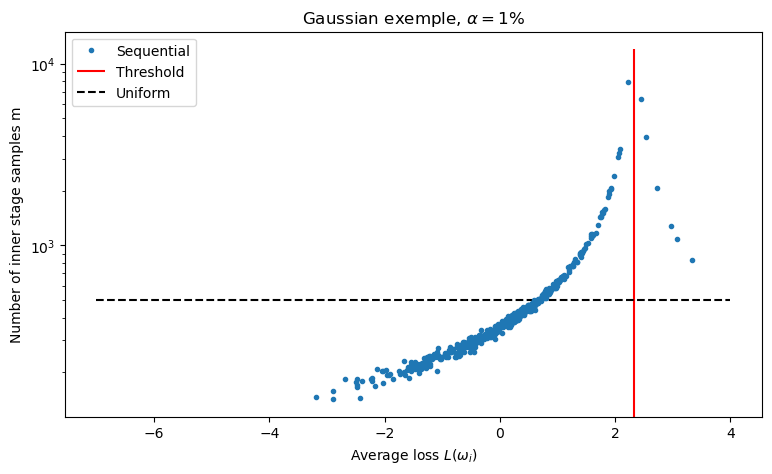

In [358]:
fix, ax = plt.subplots(figsize=(9, 5))

ax.plot(inner_losses_mean, m_array, '.', label='Sequential')
ax.vlines(x=threshold_gauss, ymin=0, ymax=12000, color='r', label='Threshold')
ax.hlines(m, -7, 4, color='k', ls='--', label='Uniform')
ax.legend()
ax.set_title(r'Gaussian exemple, $\alpha = 1\%$')
ax.set_xlabel('Average loss $L(\omega_i)$')
ax.set_ylabel('Number of inner stage samples m')
ax.set_yscale('log')

## Put option example

In [378]:
rng = np.random.default_rng(seed=0xBADBADBAD)

model_params = {
    'S0': 100,
    'K': 95,
    'T': 0.25,
    'tau': 1 / 52,
    'sigma': 0.2,
    'mu': 0.08,
    'r': 0.03,
    'X0': 1.669 # by BS formula
}

def put_simulate_scenario(size, model_params : dict = model_params, rng : np.random.Generator = rng):
    return model_params['S0'] * np.exp(
        (model_params['mu'] - 0.5 * model_params['sigma']**2) * model_params['tau'] + 
         model_params['sigma'] * np.sqrt(model_params['tau']) * rng.standard_normal(size=size)
    )

def put_simulate_inner_loss(size, scenario, model_params : dict = model_params, rng : np.random.Generator = rng):
    S_T = scenario * np.exp(
        (model_params['r'] - 0.5 * model_params['sigma']**2) * (model_params['T'] - model_params['tau']) + 
         model_params['sigma'] * np.sqrt(model_params['T'] - model_params['tau']) * rng.standard_normal(size=size)
    )
    return model_params['X0'] - np.exp(-model_params['r'] * (model_params['T'] - model_params['tau'])) * np.maximum(0, model_params['K'] - S_T)

threshold_put = 1.221


In [379]:
nested_mc_put = NestedMonteCarlo(
    simulate_scenario=put_simulate_scenario,
    simulate_inner_loss=put_simulate_inner_loss,
    loss_threshold=threshold_put
)

In [399]:
nested_mc_put.estimation_uniform(m=63, n=3968)

0.02998991935483871

In [362]:
nested_mc_put.estimation_sequential(m_init=10, m_average=1000, n=1000)

0.047

In [363]:
nested_mc_put.estimation_threshold(error_margin=50, n=10000)

0.0224

### Number of inner stage samples 

In [ ]:
import matplotlib.pyplot as plt

In [371]:
500*500

250000

In [373]:
250000**(2/3)

3968.502629920497

In [406]:
n = 3968
m = 630

_, inner_losses_mean_gauss, m_array_gauss = nested_mc_gauss.estimation_sequential(m_init=10, m_average=m, n=n, return_info=True)
_, inner_losses_mean_put, m_array_put = nested_mc_put.estimation_sequential(m_init=10, m_average=m, n=n, return_info=True)

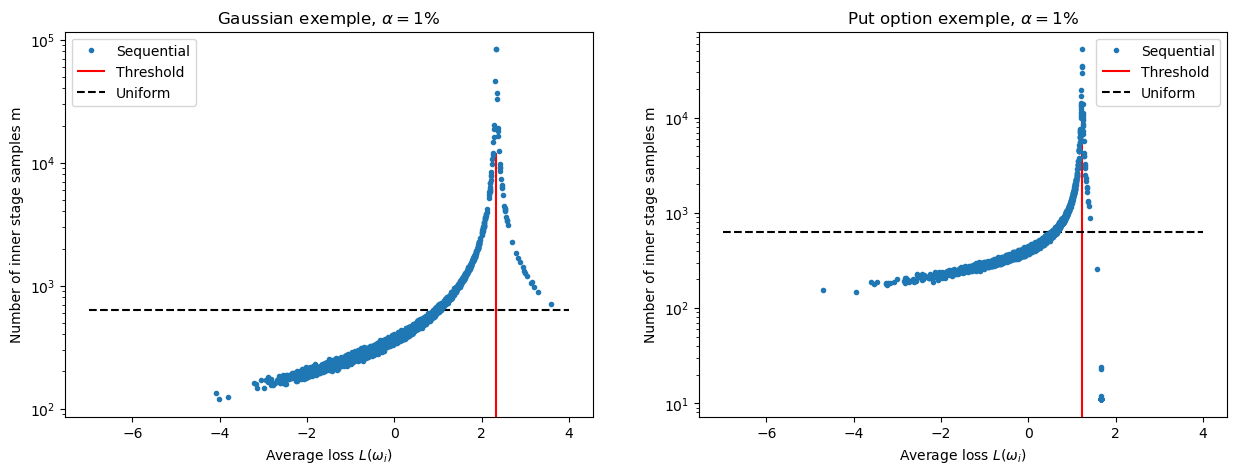

In [407]:
fix, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(inner_losses_mean_gauss, m_array_gauss, '.', label='Sequential')
ax[0].vlines(x=threshold_gauss, ymin=0, ymax=12000, color='r', label='Threshold')
ax[0].hlines(m, -7, 4, color='k', ls='--', label='Uniform')
ax[0].legend()
ax[0].set_title(r'Gaussian exemple, $\alpha = 1\%$')
ax[0].set_xlabel('Average loss $L(\omega_i)$')
ax[0].set_ylabel('Number of inner stage samples m')
ax[0].set_yscale('log')

ax[1].plot(inner_losses_mean_put, m_array_put, '.', label='Sequential')
ax[1].vlines(x=threshold_put, ymin=0, ymax=12000, color='r', label='Threshold')
ax[1].hlines(m, -7, 4, color='k', ls='--', label='Uniform')
ax[1].legend()
ax[1].set_title(r'Put option exemple, $\alpha = 1\%$')
ax[1].set_xlabel('Average loss $L(\omega_i)$')
ax[1].set_ylabel('Number of inner stage samples m')
ax[1].set_yscale('log')